# **DESCRIPTION**

This project consists of an analysis of the offers made by a company. It also focuses on those rejected both by customers and by the company itself.

Finally, a classifier model is developed to determine whether an offer will be accepted or rejected.

Companies and users names have been changed in order to protect the privacy of the data

# **Project Develop**

## *Install libraries*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

# *Import data from Excel file*

In [2]:
offer_data = pd.read_excel('OFFERS.xlsx')
offer_data.head()

,num_offer,state_offer,responsible,customer,offer_date,material,offer_amount
0,A-19/016,Adjudicada,Comercial_1,Cliente_1,2020-05-21,TC/RTD,6620.0
1,A-19/017,Adjudicada,Comercial_1,Cliente_1,2020-05-21,TC/RTD,1170.0
2,A-19/018,Adjudicada,Comercial_1,Cliente_1,2020-05-21,Skin Points,13050.0
3,A-19/019,Adjudicada,Comercial_1,Cliente_1,2020-02-03,Skin Points,38170.0
4,A-19/022,Adjudicada,Comercial_1,Cliente_1,2020-05-21,TC/RTD,2160.0


# *Data analysis*

In [3]:
offer_data.shape

(4579, 7)

In [4]:
offer_data.describe()

,offer_date,offer_amount
count,4579,4.579000e+03
mean,2019-01-16 11:33:06.721991680,4.414656e+04
min,2008-01-22 00:00:00,-1.272657e+04
25%,2015-10-20 00:00:00,1.265005e+03
50%,2020-05-11 00:00:00,4.050000e+03
75%,2023-01-24 00:00:00,1.712150e+04
max,2025-03-31 00:00:00,1.067059e+07
std,NaN,2.641579e+05


In [5]:
offer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4579 entries, 0 to 4578
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   num_offer     4579 non-null   object        
 1   state_offer   4579 non-null   object        
 2   responsible   4579 non-null   object        
 3   customer      4579 non-null   object        
 4   offer_date    4579 non-null   datetime64[ns]
 5   material      4579 non-null   object        
 6   offer_amount  4579 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 250.5+ KB


**Classify offers according their state.**

*   0: Rejected
*   1: Accepted
*   2: Pending




In [6]:
print(offer_data['state_offer'].unique().tolist())

['Adjudicada', 'Declinada', 'Perdida', 'Estimación', 'Presentada', 'Reasignada', 'Registrada']


In [7]:
mapping = {
    'Declinada': 0, 'Perdida': 0,
    'Adjudicada': 1, 'Reasignada': 1,
    'Estimación': 2, 'Presentada': 2, 'Registrada': 2
}

offer_data['offer_category'] = offer_data['state_offer'].map(mapping)

# *Calculate conversion rate*

In [8]:
conversion_rate = offer_data['offer_category'].value_counts(normalize=True)*100
print(conversion_rate)

offer_category
1    72.723302
0    22.799738
2     4.476960
Name: proportion, dtype: float64


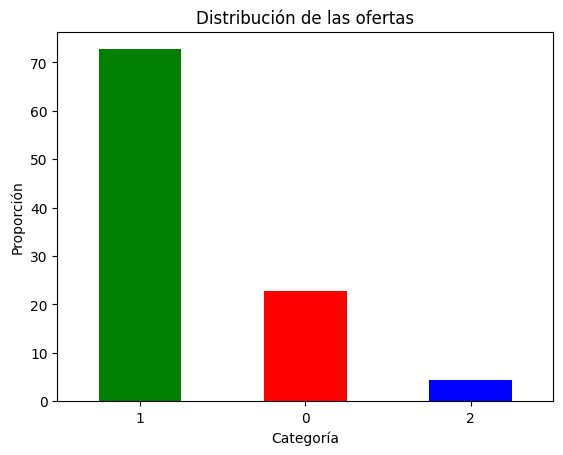

In [9]:
conversion_rate.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title("Distribución de las ofertas")
plt.xlabel("Categoría")
plt.ylabel("Proporción")
plt.xticks(rotation=0)
plt.show()

In [10]:
total_rejected = offer_data[offer_data['offer_category'] == 0]

# *Rejected offers by customer*

In [11]:
rejected_customer = total_rejected.groupby('customer').size().sort_values(ascending=False)
rejected_customer.head(10)

,0
customer,
Cliente_102,120
Cliente_3,114
Cliente_76,40
Cliente_59,38
Cliente_43,32
Cliente_132,31
Cliente_2,25
Cliente_109,23
Cliente_52,23


# *Rejected offers by equipment*

In [12]:
rejected_equipment = total_rejected.groupby('material').size().sort_values(ascending=False)
rejected_equipment.head(10)

,0
material,
Placas/Bridas,397
TC/RTD,171
RO,92
Venturis,63
Componentes Caudal,61
Componentes Temperatura,42
Bimetálicos,37
Nivel Vidrio,36
Vainas,32


# *Distribution of rejected offers*



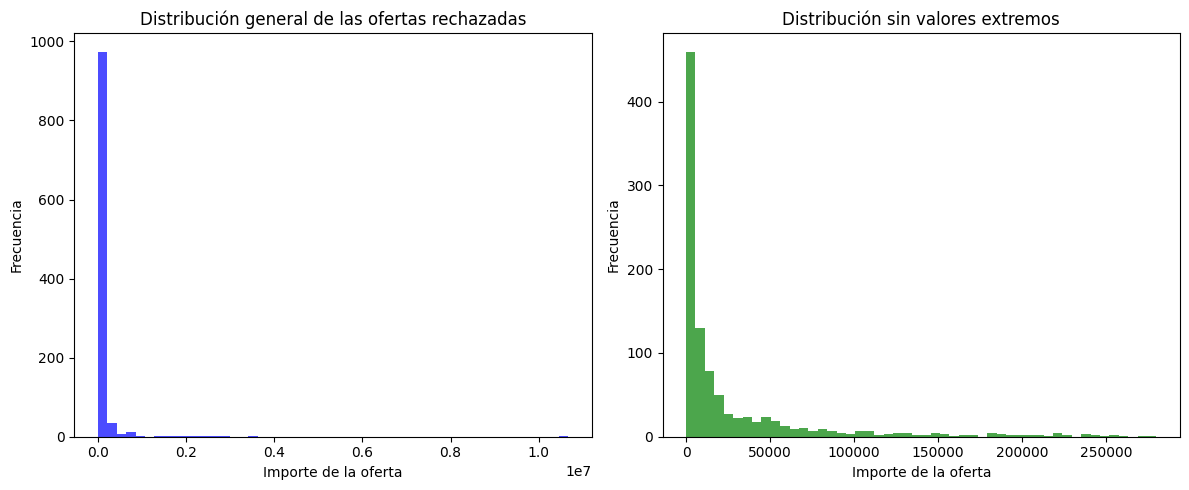

In [13]:
# Calculating percentile 95 to delete extreme values
q95 = np.percentile(total_rejected['offer_amount'], 95)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Graph1: General Data
axes[0].hist(total_rejected['offer_amount'], bins=50, color='blue', alpha=0.7)
axes[0].set_title("Distribución general de las ofertas rechazadas")
axes[0].set_xlabel("Importe de la oferta")
axes[0].set_ylabel("Frecuencia")

# Graph2: With no outliers
axes[1].hist(total_rejected['offer_amount'][total_rejected['offer_amount'] < q95], bins=50, color='green', alpha=0.7)
axes[1].set_title("Distribución sin valores extremos")
axes[1].set_xlabel("Importe de la oferta")
axes[1].set_ylabel("Frecuencia")

# Adjust layout
plt.tight_layout()
plt.show()


*As result of graphs, mostly rejected offers have amounts lower than 50.000 €*

In [14]:
print("Rejected offers with amount below 50.000 €: " + str(total_rejected[total_rejected['offer_amount'] < 50000]['offer_amount'].count()))
print("Rejected offers with amount equal or above 50.000 €: " + str(total_rejected[total_rejected['offer_amount'] >= 50000]['offer_amount'].count()))

Rejected offers with amount below 50.000 €: 830
Rejected offers with amount equal or above 50.000 €: 214


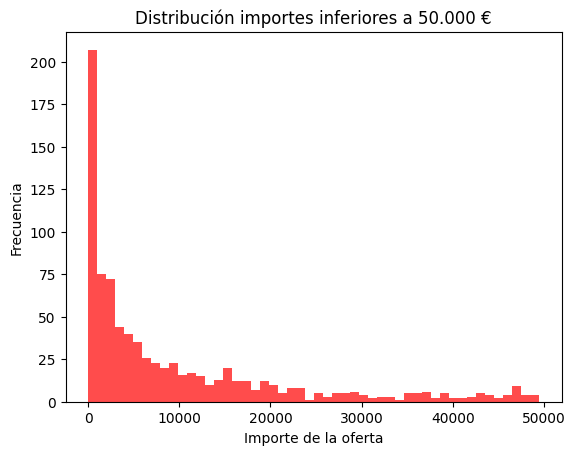

In [15]:
plt.hist(total_rejected[total_rejected['offer_amount'] < 50000]['offer_amount'], bins=50, color='red', alpha=0.7)
plt.title("Distribución importes inferiores a 50.000 €")
plt.xlabel("Importe de la oferta")
plt.ylabel("Frecuencia")

# Adjust layout
plt.show()

# *Reject rate by customer*

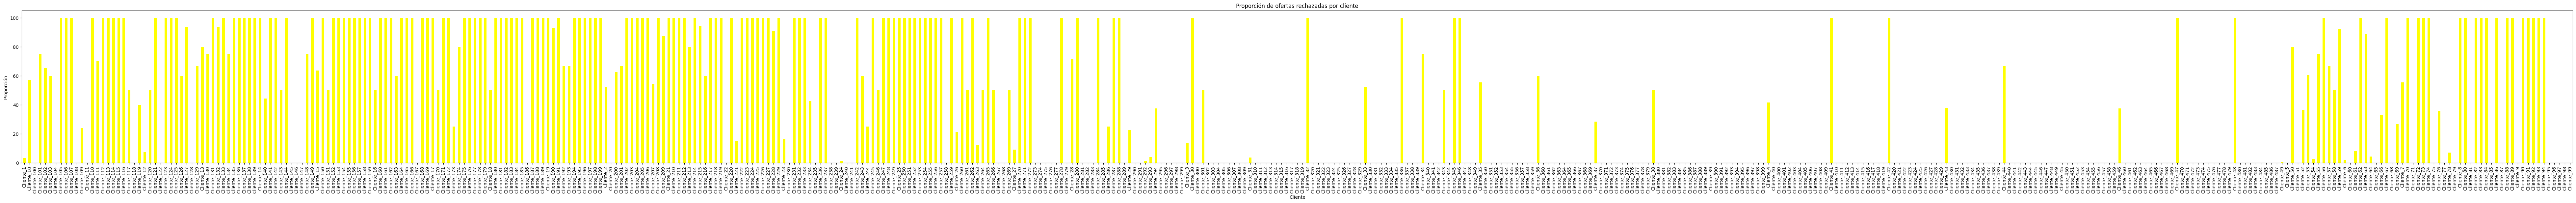

In [16]:
rejected_by_customer = total_rejected.groupby('customer').size()/offer_data.groupby('customer').size()*100
plt.figure(figsize=(100, 6))
rejected_by_customer.plot(kind='bar', color='yellow')
plt.title("Proporción de ofertas rechazadas por cliente")
plt.xlabel("Cliente")
plt.ylabel("Proporción")
plt.show()

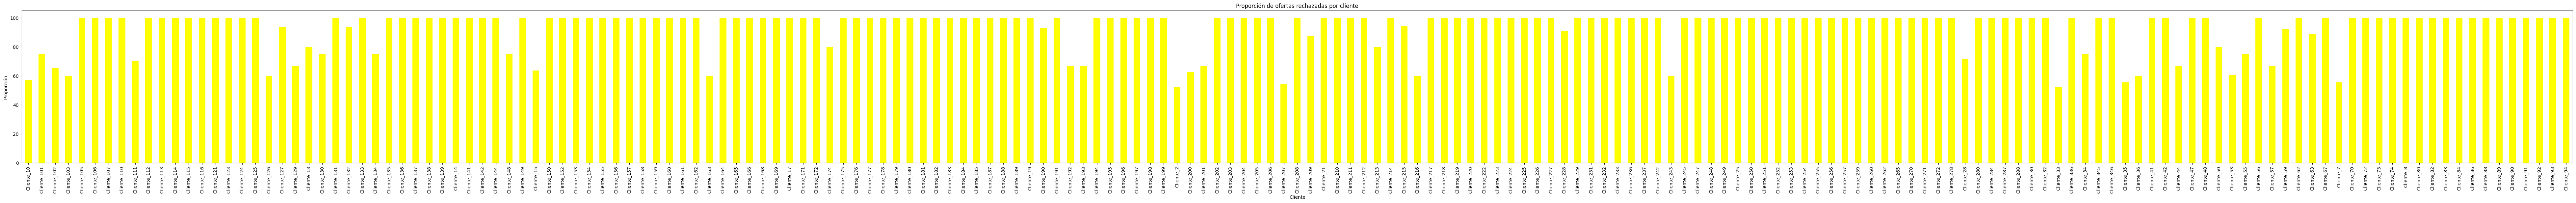

In [17]:
# Focus on those customers with rate > 50%
rejected_by_customer = total_rejected.groupby('customer').size()/offer_data.groupby('customer').size()*100
plt.figure(figsize=(100, 6))
rejected_by_customer[rejected_by_customer > 50].plot(kind='bar', color='yellow')
plt.title("Proporción de ofertas rechazadas por cliente")
plt.xlabel("Cliente")
plt.ylabel("Proporción")
plt.show()

# *Reject rate by equipment*

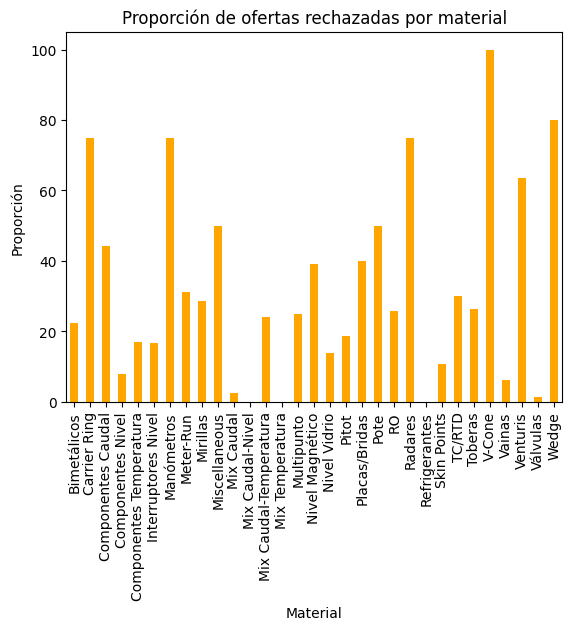

In [18]:
rejected_by_equipment = total_rejected.groupby('material').size()/offer_data.groupby('material').size()*100
rejected_by_equipment.plot(kind='bar', color='orange')
plt.title("Proporción de ofertas rechazadas por material")
plt.xlabel("Material")
plt.ylabel("Proporción")
plt.show()

# *Predicting offers*

For this case, the prediction of the acceptance is not easy because the real-life process depends on other factors that do not depend on the company and of which the details are unknown, such as the offers given by other companies or the customer's preferences in choosing a supplier.

But here is an example of what the process would be like if it depended entirely on the company.

In [19]:
df_prediction = offer_data[offer_data['offer_category'] != 2].copy()
df_prediction.head()

,num_offer,state_offer,responsible,customer,offer_date,material,offer_amount,offer_category
0,A-19/016,Adjudicada,Comercial_1,Cliente_1,2020-05-21,TC/RTD,6620.0,1
1,A-19/017,Adjudicada,Comercial_1,Cliente_1,2020-05-21,TC/RTD,1170.0,1
2,A-19/018,Adjudicada,Comercial_1,Cliente_1,2020-05-21,Skin Points,13050.0,1
3,A-19/019,Adjudicada,Comercial_1,Cliente_1,2020-02-03,Skin Points,38170.0,1
4,A-19/022,Adjudicada,Comercial_1,Cliente_1,2020-05-21,TC/RTD,2160.0,1


In [20]:
df_prediction = df_prediction.drop(columns=['state_offer','num_offer','offer_date'])
df_prediction.head()

,responsible,customer,material,offer_amount,offer_category
0,Comercial_1,Cliente_1,TC/RTD,6620.0,1
1,Comercial_1,Cliente_1,TC/RTD,1170.0,1
2,Comercial_1,Cliente_1,Skin Points,13050.0,1
3,Comercial_1,Cliente_1,Skin Points,38170.0,1
4,Comercial_1,Cliente_1,TC/RTD,2160.0,1


Coding cathegorical variables

In [21]:
label_encoder = LabelEncoder()
df_prediction['responsible'] = label_encoder.fit_transform(df_prediction['responsible'])
df_prediction['customer'] = label_encoder.fit_transform(df_prediction['customer'])
df_prediction['material'] = label_encoder.fit_transform(df_prediction['material'])

df_prediction.head()

,responsible,customer,material,offer_amount,offer_category
0,0,0,24,6620.0,1
1,0,0,24,1170.0,1
2,0,0,23,13050.0,1
3,0,0,23,38170.0,1
4,0,0,24,2160.0,1


Variables correlation

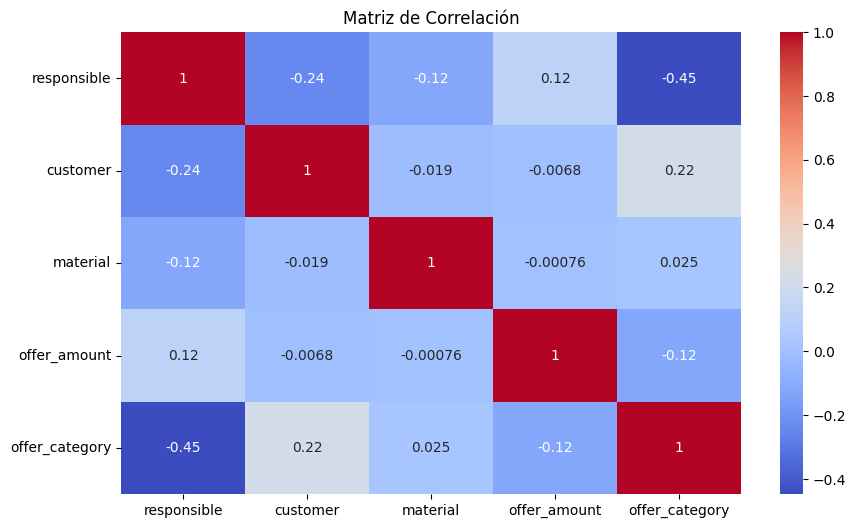

In [22]:
correlation_matrix = df_prediction.corr()

# Creating a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación")
plt.show()

Check if classes are balanced

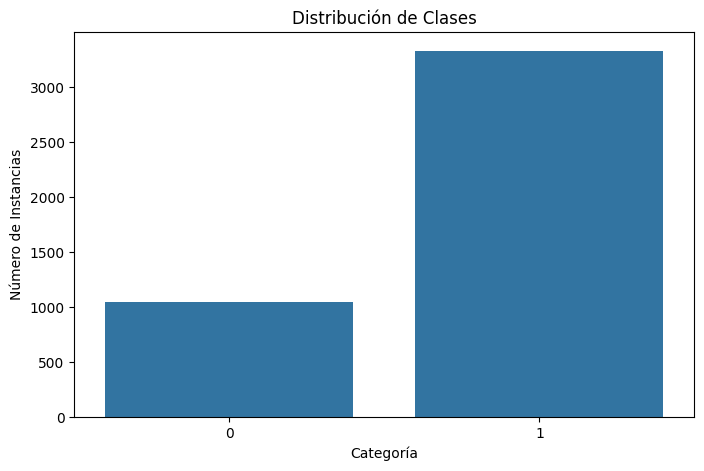

In [23]:
plt.figure(figsize=(8, 5))
sns.countplot(x='offer_category', data=df_prediction)
plt.title('Distribución de Clases')
plt.xlabel('Categoría')
plt.ylabel('Número de Instancias')
plt.show()

Classes are clearly unbalanced, so the number of instances of the minority class is increased with SMOTE

In [24]:
df_prediction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4374 entries, 0 to 4578
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   responsible     4374 non-null   int64  
 1   customer        4374 non-null   int64  
 2   material        4374 non-null   int64  
 3   offer_amount    4374 non-null   float64
 4   offer_category  4374 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 205.0 KB


Select X and y variables

In [25]:
X = df_prediction.drop(columns=['offer_category'])
y = df_prediction['offer_category']

In [26]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [27]:
print("Distribution after SMOTE:")
print(pd.Series(y_resampled).value_counts())

Distribution after SMOTE:
offer_category
1    3330
0    3330
Name: count, dtype: int64


Divide data in train and test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Select model

In [29]:
model = RandomForestClassifier(random_state=42)

Training model

In [30]:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Prediction and evaluate model

In [31]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(model.score(X_test, y_test))

              precision    recall  f1-score   support

           0       0.90      0.91      0.91       673
           1       0.91      0.89      0.90       659

    accuracy                           0.90      1332
   macro avg       0.90      0.90      0.90      1332
weighted avg       0.90      0.90      0.90      1332

[[615  58]
 [ 71 588]]
0.9031531531531531


Evaluation of model performances using Cross Validation

In [32]:
cv_scores = cross_val_score(model, X_resampled, y_resampled, cv=5, scoring='accuracy')

print("Puntuaciones de Validación Cruzada:", cv_scores)
print("Precisión Media:", cv_scores.mean())

Puntuaciones de Validación Cruzada: [0.70795796 0.92642643 0.90990991 0.91516517 0.88138138]
Precisión Media: 0.8681681681681681


Using GridSearch to obtain the best hyperparameters

In [33]:
param_grid = {
    'n_estimators': [50, 100, 200],       # Number of trees in forest
    'max_features': ['auto', 'sqrt'],     # Number of features to consider
    'max_depth': [None, 10, 20, 30],      # Maximum depth of tree
    'min_samples_split': [2, 5, 10],      # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum number of samples in a leaf node
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=2, n_jobs=-1)

# Adjust GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Results
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor puntuación de validación cruzada:", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
230 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/uti

Mejores hiperparámetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mejor puntuación de validación cruzada: 0.9042787305446185


In [34]:
# Evaluate the model with the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluating performance
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[614  59]
 [ 74 585]]
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       673
           1       0.91      0.89      0.90       659

    accuracy                           0.90      1332
   macro avg       0.90      0.90      0.90      1332
weighted avg       0.90      0.90      0.90      1332



Feature importance

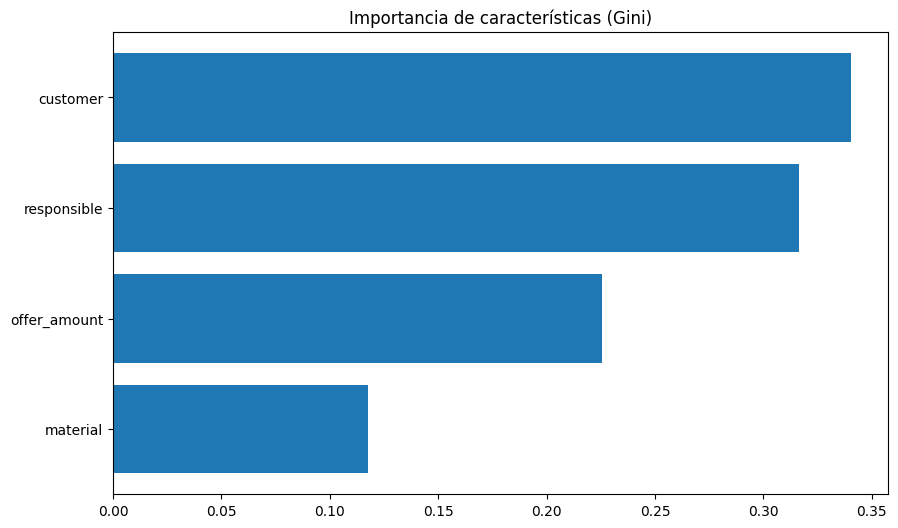

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Importancia de características
importances = model.feature_importances_
features = X_train.columns

# Ordenar y visualizar
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Gráfico
plt.figure(figsize=(10,6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Importancia de características (Gini)')
plt.show()

With this graph, it can be seen how the offer responsible has a great influence on the result. This can be due that for example one of them is selling spares of items already supplied, having a success rate over 90%, while another one is trying to expand the brand in new markets by offering to new customers, having a success rate less than 5%